In [1]:
%matplotlib inline
import random
import math
import numpy as np
import scipy.stats as st
from scipy.integrate import quad
import matplotlib.pyplot as plt
from IPython import display

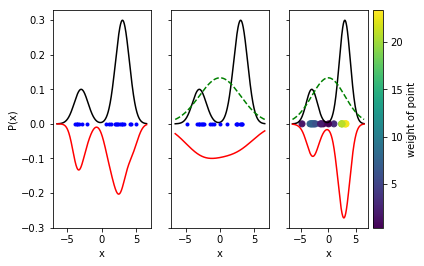

In [2]:
display.Image("./kernel.png")

In [3]:
def gaussian(x,mu,sig):
    return 1/(np.exp(np.power(x - mu,2)/(2.*np.power(sig,2)))*np.sqrt(2*np.pi)*sig)

## definition of two distributions (pdf is our P(x), sum of two gaussians while pdf0 is a simple gaussian our P'(x)) that are then used to modify the built in function _pdf of rv_continuous

In [4]:
def pdf(x):
    """A simple Gaussian Mixture Model"""
    return 0.3*gaussian(x,-3,1)+0.7*gaussian(x,3,1)
def pdf0(x):
    """A simple Gaussian"""
    return gaussian(x,0,3)

### Test pdf

In [5]:
quad(pdf0, -30,30)

(1.0000000000000002, 8.671030767590324e-10)

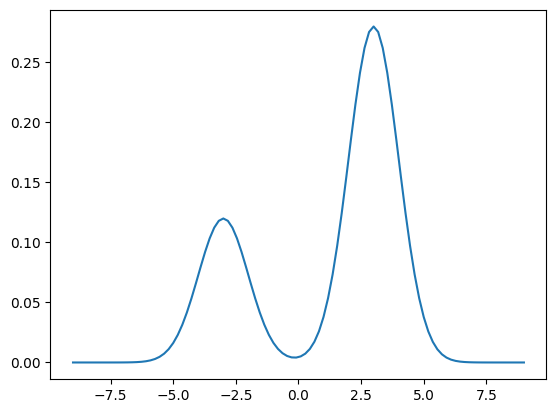

In [6]:
x = np.linspace(-9,9,100)
plt.plot(x,pdf(x));

### Test pdf0

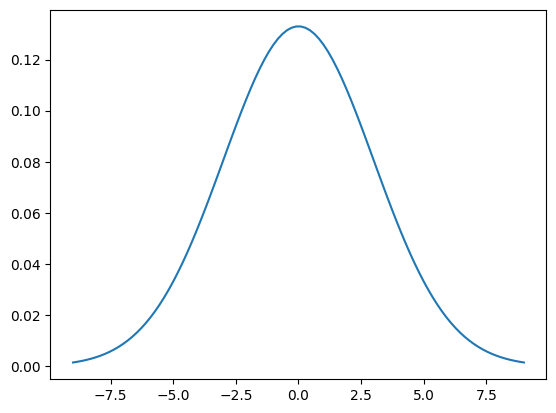

In [7]:
x = np.linspace(-9,9,100)
plt.plot(x,pdf0(x));

### rejection sampling (pdf(x) hardcoded inside)

In [8]:
max_pdf=0.3
def rejection_sampling(n_samples,xmin,xmax):
    """ Generate samples from a distribution that is the sum of two Gaussians using rejection sampling """
    samples = []
    M = 1.5  # Adjust this scale factor as needed to cover the max of the distribution

    while len(samples) < n_samples:
        # Propose a sample from a uniform distribution covering the significant range of the Gaussians
        x = random.uniform(xmin, xmax)
        # Calculate the acceptance probability
        u = random.uniform(0, M * max_pdf)
        if u < pdf(x):
            samples.append(x)
    
    return samples


# Generate 1000 samples


### random sampling with scipy

In [9]:
def random_samples(dist,npoints):
    return np.asarray([ dist.rvs() for i in range(1,npoints) ])

## we define the classes my_pdf and my_pdf0 as modifications to the standard pdf of rv_continuous

In [10]:
npoints=2000
xmin=-12
xmax=12
class my_pdf(st.rv_continuous):
    def _pdf(self,x):
        return pdf(x)  # Normalized 
class my_pdf0(st.rv_continuous):
    def _pdf(self,x):
        return pdf0(x)  # Normalized     

my_cv = my_pdf(a=xmin,b=xmax,name='my_pdf')
my_cv0 = my_pdf0(a=xmin,b=xmax,name='my_pdf0')

## "samples" and "samples0" are  sets of points randomly selected from $P(x)$ and $P'(x)$ respectively. "rej_samples" is generated with rejection sampling from $P(x)$. "x_values" is an array of $x$ values within -12 and 12

In [11]:
samples = my_cv.rvs(size=npoints)
samples0 = my_cv0.rvs(size=npoints)
rej_samples = rejection_sampling(npoints,xmin,xmax)
x_values = np.linspace(xmin,xmax,npoints)

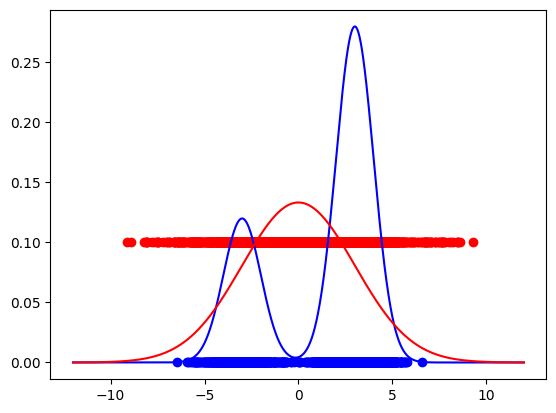

In [12]:
#plt.hist(samples,bins=200,density=True);
y=np.zeros(len(samples))
y1=y+0.1

plt.scatter(samples,y,c='blue')
plt.scatter(samples0,y1,c='red')
plt.plot(x_values,pdf(x_values),c='blue')
plt.plot(x_values,pdf0(x_values),c='red')

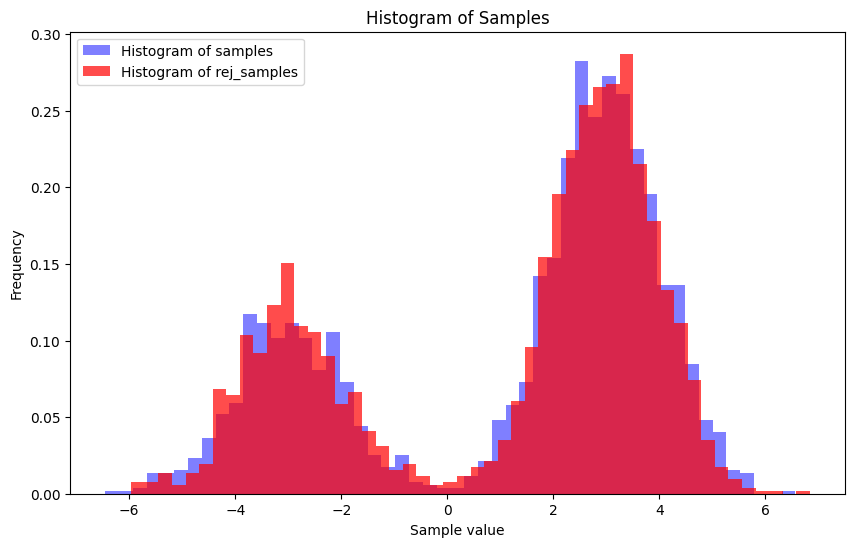

In [13]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, color='blue',density=True, alpha=0.5, label='Histogram of samples')
plt.title('Histogram of Samples')
plt.hist(rej_samples, bins=50, color='red',density=True, alpha=0.7, label='Histogram of rej_samples')
plt.title('Histogram of Samples')
plt.xlabel('Sample value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## reconstruction of the distributions with a gaussian kernel (gaussian_kde) withough weights does not produce P(x) if we use sample0

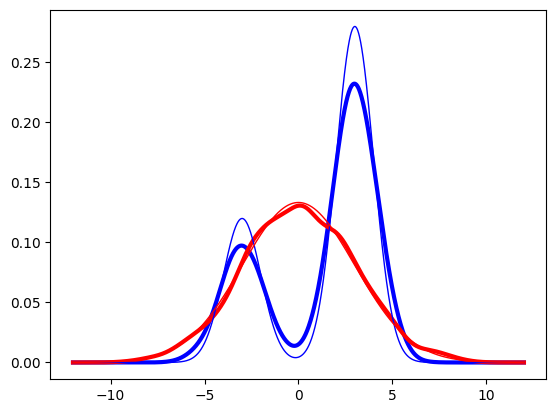

In [14]:
kernel = st.gaussian_kde(samples)
kernel0 = st.gaussian_kde(samples0)
plt.plot(x_values,kernel(x_values),c='blue',lw=3)
plt.plot(x_values,kernel0(x_values),c='red',lw=3)
plt.plot(x_values,pdf(x_values),c='blue',lw=1)
plt.plot(x_values,pdf0(x_values),c='red',lw=1)

In [15]:
quad(kernel, xmin, xmax)

(0.9999999999999998, 3.887559859547174e-12)

In [16]:
np.trapz(kernel(x_values),x_values)

0.9999999999999998

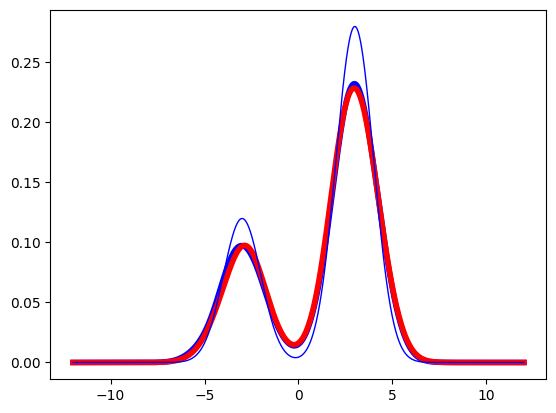

In [17]:
ws=np.ones((len(samples0)))
kernel = st.gaussian_kde(samples)
for i in range(len(samples0)):
    ws[i]=pdf(samples0[i])/pdf0(samples0[i])
    #ws=ws/np.sum(ws)
kernel_w = st.gaussian_kde(samples0,weights=ws)
plt.plot(x_values,kernel(x_values),c='blue',lw=4)
plt.plot(x_values,kernel_w(x_values),c='red',lw=4)
plt.plot(x_values,pdf(x_values),c='blue',lw=1)

In [18]:
def gaussian_kernel(x, bandwidth):
    """ Gaussian kernel function """
    return (1.0 / (np.sqrt(2 * np.pi) * bandwidth)) * np.exp(-0.5 * (x / bandwidth) ** 2)

def kde(x, data, bandwidth):
    """ Compute KDE for each x using the Gaussian kernel """
    n = len(data)
    return np.sum([gaussian_kernel((x - xi) , bandwidth) for xi in data]) / n


# Calculate bandwidth 
std_dev = samples.std()
silverman_bandwidth = 1.06 * std_dev * npoints ** (-1 / 5) 
scotts_bandwidth = npoints**(-1/5) * std_dev  # Simplified for univariate data


# Compute KDE values
kde_values = [kde(x, samples, scotts_bandwidth) for x in x_values]

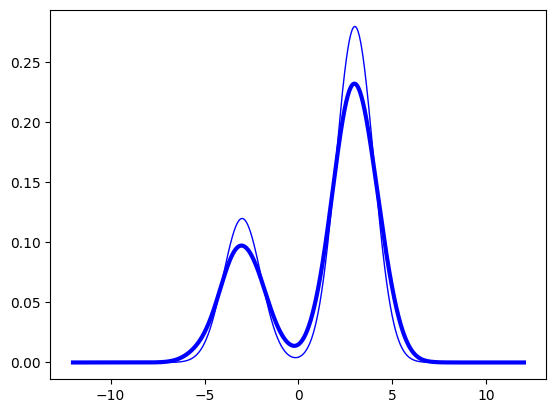

In [19]:
plt.plot(x_values,np.array(kde_values),c='blue',lw=3)
plt.plot(x_values,pdf(x_values),c='blue',lw=1)

In [20]:
quad(gaussian_kernel, xmin, xmax, args=(scotts_bandwidth))

(1.0000000000000002, 3.624351651318556e-10)

In [21]:
np.trapz(np.array(kde_values),x_values)

1.0000000000000002